In [99]:
from google.colab import drive
drive.mount('/content/drive')

%cd ./drive/MyDrive/RRCGAN_SMILES_publish/analysis

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/MyDrive/RRCGAN_SMILES_publish/analysis'
/content/drive/MyDrive/RRCGAN_SMILES_publish/analysis
/content/drive/My Drive/RRCGAN_SMILES_publish/analysis


In [100]:
# Task:
# postprocessing analysis
# use Joback method (using functional groups to calc. Cv) 
# find the rep. with qm9 and save the final file in a .csv file
# Joback has 6% error on qm9 values
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#! pip install rdkit-pypi
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem
print ("!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!")
#! pip install thermo
from thermo import Joback
# loading SMILES data using Chainer Chemistry
#! pip install chainer_chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor



!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!


In [101]:
# load the generated SMILES from the RCGAN Model
csv_name = './../experiments/regular_9HA_6b6latent/Regular_noscreen.csv'
gen_SMILES = pd.read_csv(csv_name)

gen_SMILES_initial = gen_SMILES
initial_num_samples = gen_SMILES.shape[0]
print ('Number of gen SMILES', gen_SMILES.shape[0])
sanitized_idx = []
# make sure about Canonical SMILES
for i, s in enumerate (gen_SMILES['SMILES'].values):
    try:
         m = Chem.MolFromSmiles(s, sanitize=True)
         ss = Chem.MolToSmiles(m)
         gen_SMILES['SMILES'].values[i] = ss
         sanitized_idx.append(i)
    except:
         print (s, 'is not sanitized')
gen_SMILES = gen_SMILES.iloc[sanitized_idx]
gen_SMILES.reset_index(drop = True, inplace = True)

print ('Number of gen SMILES after getting Canonical', gen_SMILES.shape[0])

Number of gen SMILES 727
N=C1=N(NN)C=C1 is not sanitized
Number of gen SMILES after getting Canonical 726


Total SMILES validated by Joback 704 Vs. total gen_SMILES 726
(704, 5)
mean error Joback(gen_SMILES) Vs. des. value:  0.13742900064145203
mean error Joback(gen_SMILES) Vs. pred. value:  0.07107019428018037
the first smile in val_accurate:  C#CC1=CC(=C)CO1
mean error Joback(gen_SMILES) Vs.Predicted from regressor (for accurate Cv(<10%):  0.07107019428018037
mean error Joback(gen_SMILES) Vs.Desired from regressor (for accurate Cv(<10%):  0.13742900064145203


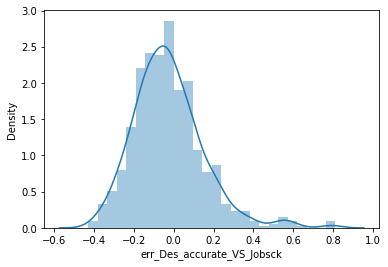

In [102]:
# pick the samples with available Joback values
jobacks = []
validated_smiles = []
valid_ids = []
for count, s in enumerate(gen_SMILES['SMILES'].values):
    try:
        J = Joback(s)
        jobacks.append(J.Cpig(298.15) * 0.2390057361)
        validated_smiles.append(s)
        valid_ids.append(count)     
    except:
        pass
print ("Total SMILES validated by Joback {} Vs. total gen_SMILES {}".\
        format(len(validated_smiles), len(gen_SMILES['SMILES'])))

gen_SMILES2 = gen_SMILES.iloc[valid_ids, :]
gen_SMILES2['jobacks'] = jobacks
print (gen_SMILES2.shape)

""" error using Joback method mean """
# Joback vs. Des. 
gen_SMILES2['Err_joback_des'] = np.abs(
    (gen_SMILES2['des_cv'].values - gen_SMILES2['jobacks'].values)/
     gen_SMILES2['jobacks'].values)
print ("mean error Joback(gen_SMILES) Vs. des. value: ", 
       np.mean(gen_SMILES2['Err_joback_des'].values))
# Joback vs. Pred.
gen_SMILES2['Err_joback_pred'] = np.abs(
    (gen_SMILES2['pred_cv'].values - gen_SMILES2['jobacks'].values)/  
     gen_SMILES2['jobacks'].values)
print ("mean error Joback(gen_SMILES) Vs. pred. value: ", 
       np.mean(gen_SMILES2['Err_joback_pred'].values))

gen_SMILES2.reset_index(drop = True, inplace = True)

csv_name = csv_name.replace('.csv', '') 
gen_SMILES2.to_csv('{}_jobackadded.csv'.format(csv_name), index = False)

""" screen candidates in generated SMILES with close to Joback values """
val_accurate = pd.DataFrame({'SMILES': [],
                             'des_cv': [],
                             'pred_cv': [],
                             'jobacks': []})
accurate = []

for i, s in enumerate (gen_SMILES2['SMILES'].values):
    if gen_SMILES2['Err_joback_des'].values[i] > 0:
        accurate.append(i)

for ii, a in enumerate (accurate):
    #print (" i and a from accurate",ii, a)
    val_accurate.loc[ii,:] = gen_SMILES2.iloc[a,:]

print ("the first smile in val_accurate: ",val_accurate['SMILES'].values[0])
for i, s in enumerate (val_accurate['SMILES'].values):
    #print (s)
    m = Chem.MolFromSmiles(s)
    ss = Chem.MolToSmiles(m)
    val_accurate['SMILES'].values[i] = ss

sort_val_accurate = val_accurate.sort_values ('des_cv')
#print (sort_val_accurate) 

# accuracy of the the model Joback vs. predicted and desired Cv (accurate < 5%)
mean_err = np.mean(np.abs((val_accurate['pred_cv'].values - 
                           val_accurate['jobacks'].values) / 
                           val_accurate['jobacks'].values))
print ("mean error Joback(gen_SMILES) Vs.Predicted from regressor (for accurate Cv(<10%): ", mean_err)


mean_err = np.mean(np.abs((val_accurate['des_cv'].values -
                           val_accurate['jobacks'].values) /
                           val_accurate['jobacks'].values))
print ("mean error Joback(gen_SMILES) Vs.Desired from regressor (for accurate Cv(<10%): ", mean_err)


num_acc_l0p1 = np.sum(np.abs((gen_SMILES2['des_cv'].values - 
                              gen_SMILES2['jobacks'].values) / 
                              gen_SMILES2['jobacks'].values) < 0.1)

plt.scatter(gen_SMILES2['des_cv'].values, gen_SMILES2['jobacks'].values)
plt.savefig("Desired_VS_joback.png")

plt.clf()
plt.scatter(val_accurate['des_cv'].values, val_accurate['jobacks'].values)
plt.title("Accurate Desired Cv vs. Joback Cv")
plt.xlabel("Desired Cv")
plt.ylabel("Joback Cv")
plt.savefig("Desired_accurate_VS_joback.png")

plt.clf()
#sns.distplot(np.abs((val['des_cv'].values - val['jobacks'].values) / val['jobacks'].values))
sns.distplot(((gen_SMILES2['des_cv'].values - gen_SMILES2['jobacks'].values) / gen_SMILES2['jobacks'].values))

plt.savefig("err_Des_VS_Jobsck.png")

plt.clf()
err_Desacc_job = ((val_accurate['des_cv'].values - val_accurate['jobacks'].values) / val_accurate['jobacks'].values)
err_Desacc_job = pd.Series(err_Desacc_job, name="err_Des_accurate_VS_Jobsck")
sns.distplot(err_Desacc_job)
plt.savefig("err_Des_accurate_VS_Jobsck.png")
val_accurate.reset_index(drop = True, inplace = True)

First SMILES in qm9 COC=Nc1ccco1
First SMILES in qm9 COC=Nc1ccco1
same generated SMILES compared to qm9 lib is:               SMILES   des_cv    pred_cv  Err_pred_des         cv
0      CC1CC2OCC2C1=O  37.6154  31.171692      0.171305  30.586000
1    CC1CC2(C=O)CC2O1  32.0303  31.481295      0.017140  32.054001
2    C#CC1C2CCC(O)C12  28.6865  33.144875      0.155417  32.751999
3      C#CC(C)(O)CCCC  41.6658  41.571800      0.002256  42.048000
4            O=COCCCO  23.4416  27.282890      0.163866  27.209000
..                ...      ...        ...           ...        ...
252   O=C1CC(O)C2CC12  25.3460  27.312103      0.077571  27.209000
253    Cn1cc(F)cnc1=N  25.3460  29.076809      0.147195  28.746000
254     CCCC1(C)CCC1C  40.6251  41.416985      0.019492  41.608002
255  CC12CCC(C#N)C1C2  30.0560  32.539710      0.082636  32.591999
256   C#CC12CCC(C1)O2  26.3572  27.740482      0.052482  26.892000

[257 rows x 5 columns]
mean of rel diff BW Desired (sampled in design model) and cv 

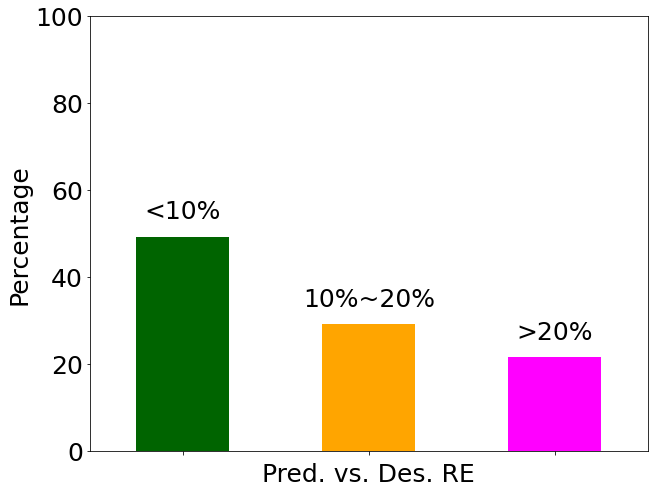

In [103]:
#val_accurate.to_csv('gen_new_noscreen_all_joback.csv', index = False)
preprocessor = GGNNPreprocessor()
"""

data = get_molnet_dataset('qm9',
                          labels = 'cv',
                          preprocessor = preprocessor,
                          return_smiles = True,
                          frac_train = 1.0,
                          frac_valid = 0.0,
                          frac_test = 0.0
                         )
""" 
with open('./../data/trainingsets/Data.pickle', 'rb') as f:
    data = pickle.load (f)

SMILES_ = data['smiles'][0]
print ('First SMILES in qm9', SMILES_[0])
SMILES = []

# save as canonical SMILES to find duplicates
# the gen smiles already converted to Canonical
for s in SMILES_:
    m = Chem.MolFromSmiles (s)
    ss = Chem.MolToSmiles(m)
    SMILES.append(ss)
#SMILES = SMILES.astype('str')
print ('First SMILES in qm9', SMILES[0])

data_SMILES = []
data_cv_ = []
for i, s in enumerate(SMILES):
    data_SMILES.append(s)
    data_cv_.append(data['dataset'][0][i][2][0])



data_cv = np.array(data_cv_)
data_SMILES = np.array(data_SMILES)

#gen_unique = gen_SMILES['SMILES'].values

data = {}
data['SMILES'] = data_SMILES
data['cv'] = data_cv_
data = pd.DataFrame(data)

# find the repetitives
database_samples = pd.merge(gen_SMILES, data, on = 'SMILES', how = 'inner')
print ( "same generated SMILES compared to qm9 lib is:{}".format(database_samples))
rep_smiles = database_samples['SMILES'].tolist()
for i in range(gen_SMILES.shape[0]):
    if (gen_SMILES['SMILES'][i] in rep_smiles):
        gen_SMILES = gen_SMILES.drop(i)

gen_SMILES.reset_index(drop=True, inplace=True)
csv_name = csv_name.replace('.csv', '')
gen_SMILES.to_csv('{}_qm9removed.csv'.format(csv_name), index = False)

# get the relative error of Desired Cv vs Cv from qm9 for generated SMILES that are repetitive and are in qm9
mean_rel_diff_desired_cvqm9 = np.mean(np.abs((database_samples['des_cv'].values -
                                              database_samples['cv'].values) / 
                                              database_samples['cv'].values))
print ("mean of rel diff BW Desired (sampled in design model) and cv from qm9: {}".
                                                 format(mean_rel_diff_desired_cvqm9))


mean_rel_diff_desired_cvqm9 = np.mean(np.abs((database_samples['pred_cv'].values
                       - database_samples['cv'].values) / database_samples['cv'].values))
print ("mean of rel diff BW Predicted (from regresor) and cv from qm9: {}".
                                                 format(mean_rel_diff_desired_cvqm9))

# plot the error bars <10%, <20%
re_less_10 = np.sum(gen_SMILES['Err_pred_des'].values <= 0.1)
print (
    'less than 10 % ', re_less_10, 
    'from total ', gen_SMILES.shape[0], 
    re_less_10/gen_SMILES.shape[0], "%")
re_less_20_big_10 = np.sum( (gen_SMILES['Err_pred_des'].values > 0.1) &  (gen_SMILES['Err_pred_des'].values <= 0.2) )
print ('less than 20 larger than 10% ', re_less_20_big_10, 'from total ', gen_SMILES.shape[0], re_less_20_big_10/gen_SMILES.shape[0], "%")
re_big_20 = np.sum(gen_SMILES['Err_pred_des'].values > 0.2)
print ('larger than 20 % ', re_big_20, 'from total ', gen_SMILES.shape[0], re_big_20/gen_SMILES.shape[0], "%")
print ('total: ', re_less_10 + re_less_20_big_10 + re_big_20)

plt.figure(figsize = (10, 8))
frequencies = [re_less_10/len(gen_SMILES)*100, re_less_20_big_10/len(gen_SMILES)*100, re_big_20/len(gen_SMILES)*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', color = ['darkgreen', 'orange', 'magenta'])
rects = ax.patches
x_labels = [ ]
labels = ['<10%', '10%~20%', '>20%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, label,fontsize = 25,
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0,100)
plt.yticks(fontsize = 25)
plt.ylabel("Percentage", fontsize=25)
plt.xlabel("Pred. vs. Des. RE", fontsize=25)
plt.savefig('Err_pred_des_dist_3part.png', dpi=300)


469 unique samples from total of 727
-0.4906762089242649
-0.4958298925832758
MAE_pred_des 5.931102257988844
Fractioned MAE_pred_des 0.1906829323450013
RMSE_pred_des 7.1216046295613
Fractioned_RMSE_pred_des 0.23264964867968668


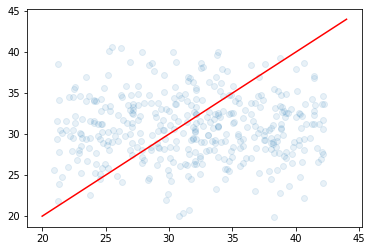

In [133]:
des_cv = np.array (gen_SMILES['des_cv'])
pred_cv = np.array (gen_SMILES['pred_cv'])
pred_cv = np.random.normal (31, 4, des_cv.shape[0])
print ("{} unique samples from total of {}".format(des_cv.shape[0], initial_num_samples))

np.random.seed(0)
# sampling the generated ones
idx = np.random.choice (range(0, des_cv.shape[0]), 400, replace=False)

des_cv_sampled = des_cv[idx]
pred_cv_sampled = pred_cv[idx]

plt.scatter (des_cv_sampled, pred_cv_sampled, alpha=0.1)
plt.plot([20, 44], [20, 44], color='red')

print (r2_score(des_cv_sampled, pred_cv_sampled))
print (r2_score(des_cv, pred_cv))

N = des_cv.shape[0]
MAE_pred_des = mean_absolute_error(pred_cv, des_cv)
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, des in zip(pred_cv, des_cv):
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

# root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
RMSE_pred_des = mean_squared_error(pred_cv, des_cv)**0.5
print ("RMSE_pred_des", RMSE_pred_des)

Fractioned_RMSE_pred_des = 0
for pred, des in zip(pred_cv, des_cv):
    Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)



In [134]:
# calculate Pearson's coefficient 
rho = np.corrcoef (des_cv_sampled, pred_cv_sampled)
print (rho**2)

[[1.0000000e+00 9.8737744e-06]
 [9.8737744e-06 1.0000000e+00]]


In [122]:
""" reading and preprocessing data"""
with open('./../data/trainingsets/60000_train_regular_qm9/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train0 = pickle.load(f)
    
with open('./../data/trainingsets/60000_train_regular_qm9/image_test.pickle', 'rb') as f:
    X_smiles_val, SMILES_val, X_atoms_val, X_bonds_val, y_val0 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_qm9/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '



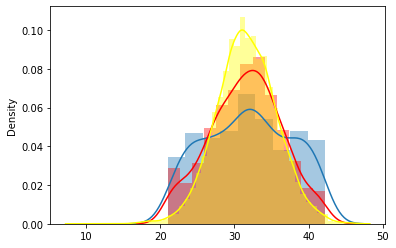

In [106]:
sns.distplot(des_cv)
sns.distplot(pred_cv, color='red')
sns.distplot(y_val0, color='yellow')

In [107]:
print (np.min(des_cv))
print (np.max(des_cv))

20.9706
42.2146
